In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime



In [8]:
#Import all csv files into a dictionary

from pathlib import Path

# 1. Get your paths (as Path objects for easy naming)
directory = Path("../data/sample")
paths = [f for f in directory.rglob("NP6*.csv")]

print(paths)

# 2. Create the dictionary
# Key = file name without extension (.stem)
# Value = the loaded DataFrame
data_dict = {f.stem: pd.read_csv(f) for f in paths}

# 3. Access your data by name
print(data_dict.keys())  # See all your table names
# example_df = data_dict['january_report']




[WindowsPath('../data/sample/ercot/NP6-331-CD/2025/12/NP6-331-CD_202512.csv'), WindowsPath('../data/sample/ercot/NP6-346-CD/2025/12/NP6-346-CD_202512.csv'), WindowsPath('../data/sample/ercot/NP6-788-CD/2025/12/NP6-788-CD_202512.csv'), WindowsPath('../data/sample/ercot/NP6-905-CD/2025/12/NP6-905-CD_202512.csv')]
dict_keys(['NP6-331-CD_202512', 'NP6-346-CD_202512', 'NP6-788-CD_202512', 'NP6-905-CD_202512'])


In [9]:
type(data_dict.keys())

list = [f for f in data_dict.keys()]

for x, y in data_dict.items():
    print(y.columns)




Index(['DeliveryDate', 'DeliveryHour', 'DeliveryInterval', 'RepeatedHourFlag',
       'ASType', 'MCPC'],
      dtype='str')
Index(['OperDay', 'HourEnding', 'NORTH', 'SOUTH', 'WEST', 'HOUSTON', 'TOTAL',
       'DSTFlag'],
      dtype='str')
Index(['SCEDTimestamp', 'RepeatedHourFlag', 'SettlementPoint', 'LMP'], dtype='str')
Index(['DeliveryDate', 'DeliveryHour', 'DeliveryInterval',
       'SettlementPointName', 'SettlementPointType', 'SettlementPointPrice',
       'DSTFlag'],
      dtype='str')


In [ ]:
df = data_dict[list[0]]

df.sample, df.columns

#df.DeliveryInterval.unique()

(<bound method NDFrame.sample of       DeliveryDate  DeliveryHour  DeliveryInterval RepeatedHourFlag ASType  \
 0       2025-12-04            24                 4                N   ECRS   
 1       2025-12-04            24                 4                N  NSPIN   
 2       2025-12-04            24                 4                N  REGDN   
 3       2025-12-04            24                 4                N  REGUP   
 4       2025-12-04            24                 4                N    RRS   
 ...            ...           ...               ...              ...    ...   
 12955   2025-12-31            24                 1                N   ECRS   
 12956   2025-12-31            24                 1                N  NSPIN   
 12957   2025-12-31            24                 1                N  REGDN   
 12958   2025-12-31            24                 1                N  REGUP   
 12959   2025-12-31            24                 1                N    RRS   
 
        MCPC  
 0 

Ancillary Services market deals with "readiness"—paying generators to be on standby in case things go wrong. This dataset tell us how much it costs to keep the grid stable (Prices for Readiness)


Here is some information about the data:

|Column Name|	Data Type|	Description|
|:---       |:---        |:---         |
|DeliveryDate|	Date|	The calendar day of the market activity.|
|DeliveryHour|	Integer|	The Hour Ending (HE). Represents the 60-minute block ending at this hour.|
|DeliveryInterval|	Integer|	The 15-minute slice within the DeliveryHour (numbers 0-4)|
|RepeatedHourFlag	|String|	Handles Daylight Saving Time (DST).|
|ASType|	String|	The specific Ancillary Service being priced.|
MCPC|	Decimal|	Market Clearing Price for Capacity. The price paid to the resource.|

Reg-Up / Reg-Down: Capacity used to balance small, second-by-second fluctuations in frequency.

Responsive Reserve (RRS): Capacity that can jump onto the grid very quickly if a large power plant suddenly trips offline.

Non-Spinning Reserve (Non-Spin): Capacity that can be ready within 30 minutes.

ERCOT Contingency Reserve Service (ECRS): A newer service for rapid response to grid instability.

We will create timestamps using Date, Hour, and Interval to get a more better plot for MCPC of the ancillary services.

In [47]:
df['Timestamp']= pd.to_datetime(df['DeliveryDate'])

df['Timestamp'] += pd.to_timedelta(df['DeliveryHour'] - 1, unit='h')
df['Timestamp'] += pd.to_timedelta((df['DeliveryInterval'] - 1) * 15, unit='m')

df = df.sort_values(by="Timestamp", ascending=True)
df.head(5)




,DeliveryDate,DeliveryHour,DeliveryInterval,RepeatedHourFlag,ASType,MCPC,Timestamp
0,2025-12-04,24,4,N,ECRS,9.34,2025-12-04 23:45:00
1,2025-12-04,24,4,N,NSPIN,9.34,2025-12-04 23:45:00
2,2025-12-04,24,4,N,REGDN,9.96,2025-12-04 23:45:00
3,2025-12-04,24,4,N,REGUP,9.33,2025-12-04 23:45:00
4,2025-12-04,24,4,N,RRS,9.37,2025-12-04 23:45:00


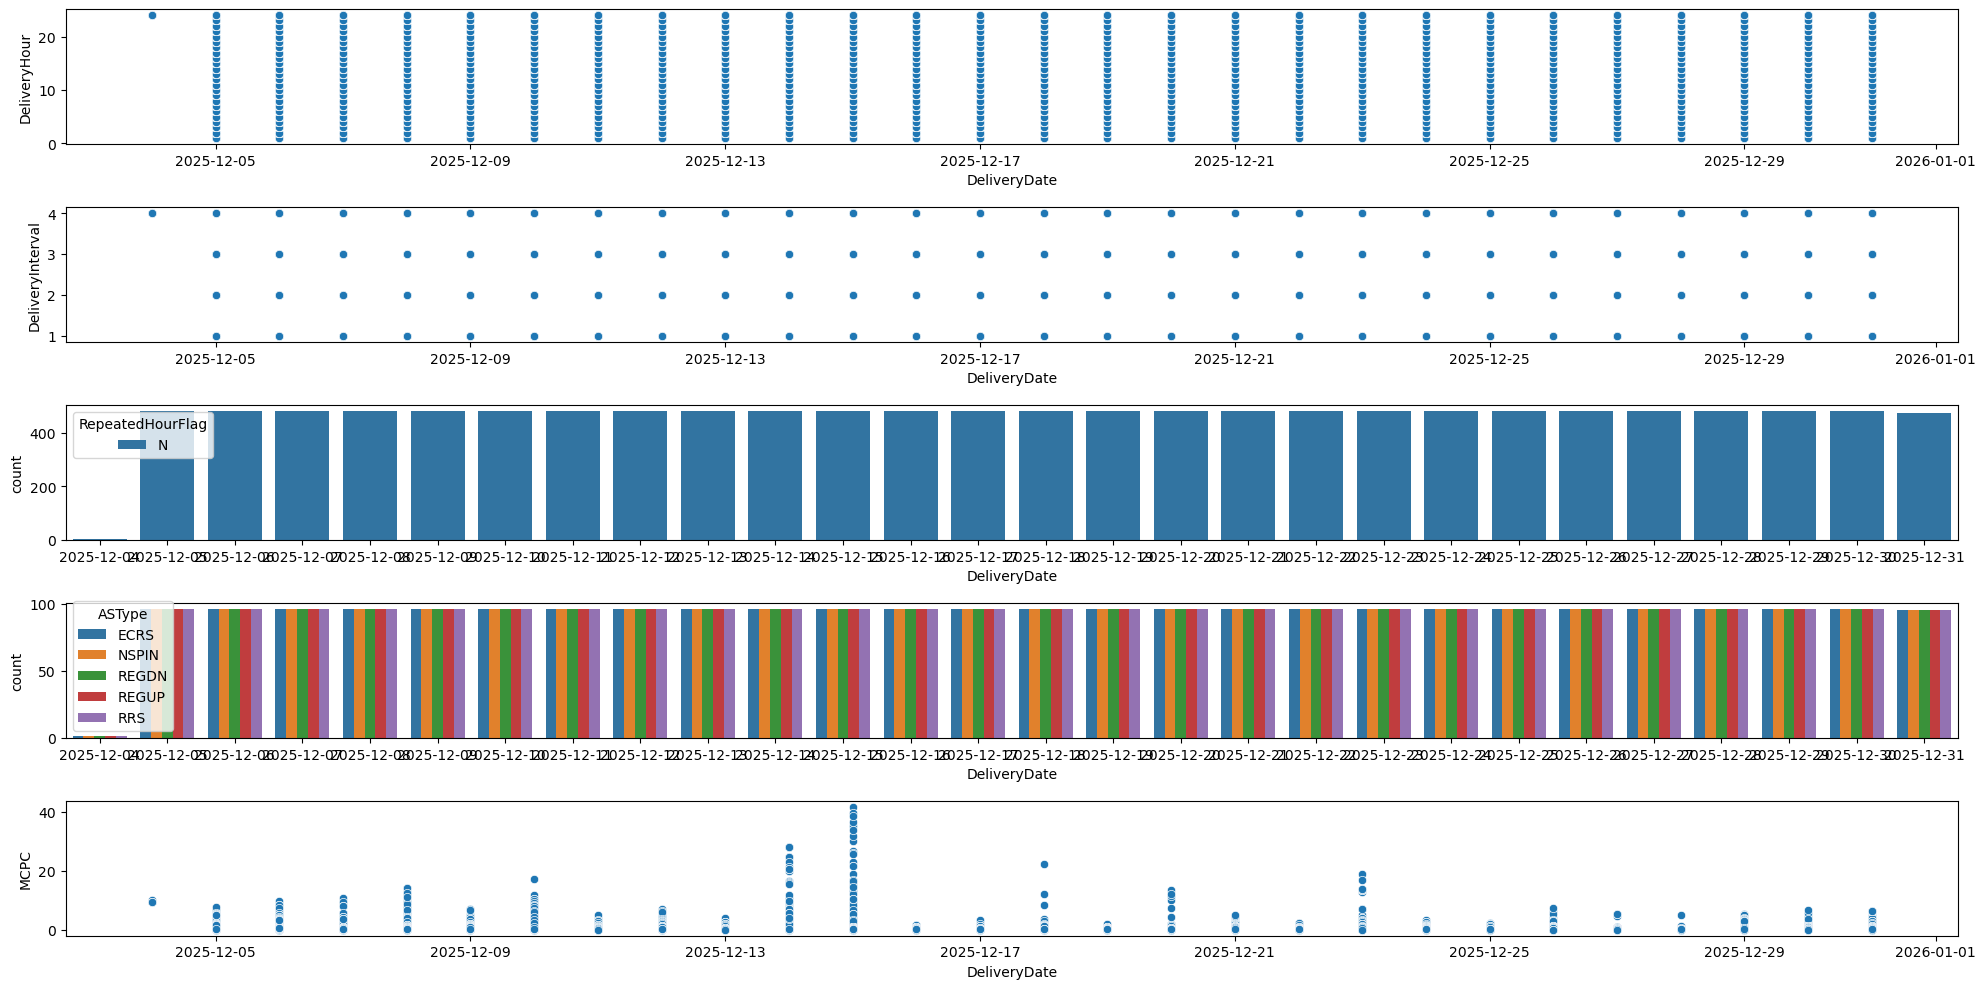

In [48]:
# Create a 2x2 grid
fig, axes = plt.subplots(5, 1, figsize=(20, 10))

# Top Left
sns.scatterplot(data=df, x="DeliveryDate", y="DeliveryHour", ax=axes[0])

# Top Right
sns.scatterplot(data=df, x="DeliveryDate", y="DeliveryInterval", ax=axes[1])

# Bottom Left
sns.countplot(data=df, x="DeliveryDate",hue="RepeatedHourFlag",ax=axes[2])

# Bottom Right
sns.countplot(data=df, x="DeliveryDate", hue="ASType", ax=axes[3])

sns.scatterplot(data=df, x="DeliveryDate", y="MCPC", ax=axes[4])


plt.tight_layout()




This is not particulary useful. It turns out upon probing a little that ASType need to be a hue for the plots because ASType represents the various ancillary services that are being paid for.

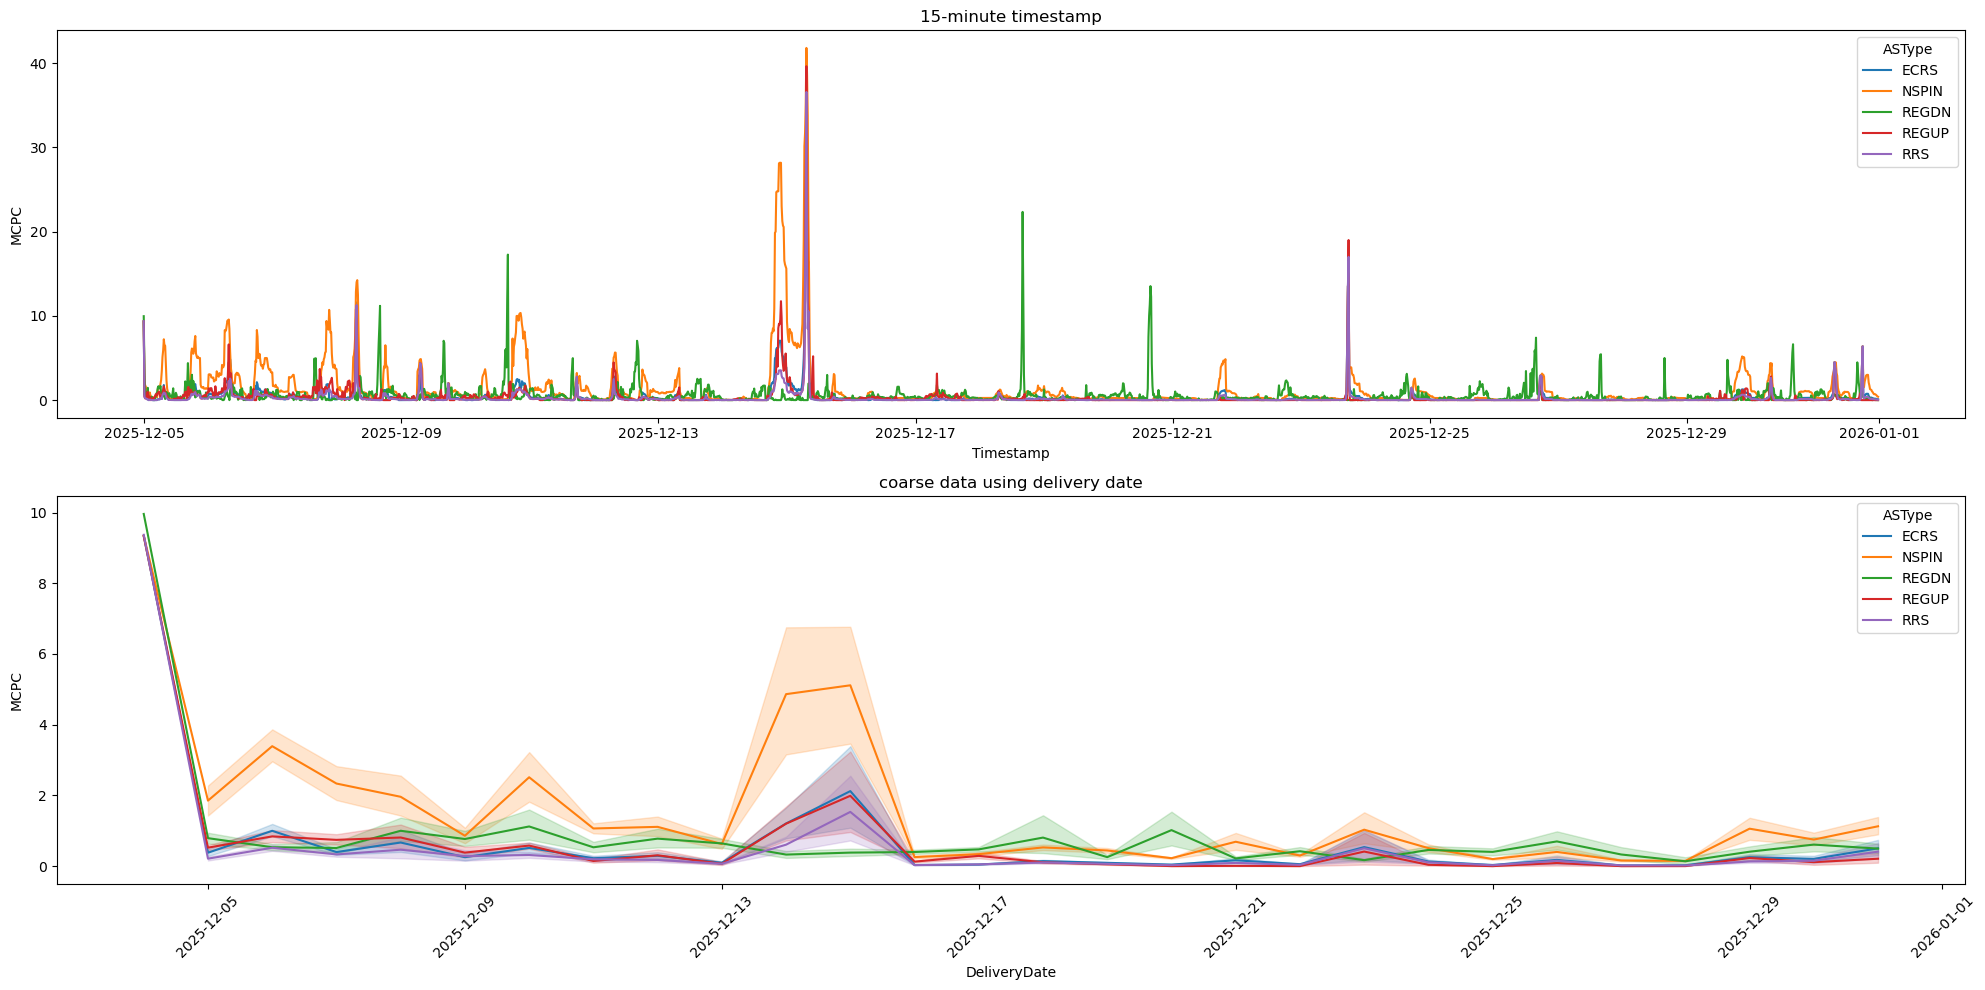

In [54]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Plot using 15minute timestamp
sns.lineplot(data=df, x="Timestamp", y="MCPC", hue="ASType", ax=axes[0],).set(title='15-minute timestamp')

sns.lineplot(data=df,x='DeliveryDate',y='MCPC',hue='ASType',ax=axes[1]).set(title='coarse data using delivery date')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [52]:
#for x in df['ASType'].unique():
 #   print(df.loc['ASType'==x].count())

df['ASType'].value_counts()

ASType
ECRS     2592
NSPIN    2592
REGDN    2592
REGUP    2592
RRS      2592
Name: count, dtype: int64

In [18]:
dg = data_dict[list[1]]
dg.columns


Index(['OperDay', 'HourEnding', 'NORTH', 'SOUTH', 'WEST', 'HOUSTON', 'TOTAL',
       'DSTFlag'],
      dtype='str')

This Dataset contains information about the actual load in real time

We will make a plot of the actual load for the various region and a separate one for the Houston area.

In [25]:
dg.loc[dg['HourEnding']=='24:00','HourEnding'] = '00:00'

dg['Date'] = dg['OperDay'] +' '+ dg['HourEnding']



dg['Date'] = pd.to_datetime(dg['Date'], format="%m/%d/%Y %H:%M")
dg.sample(5)

,OperDay,HourEnding,NORTH,SOUTH,WEST,HOUSTON,TOTAL,DSTFlag,Date
587,12/25/2025,12:00,14812.08,12309.78,9461.39,12201.12,48784.37,N,2025-12-25 12:00:00
302,12/13/2025,15:00,15339.85,13144.97,9447.62,12895.92,50828.36,N,2025-12-13 15:00:00
112,12/05/2025,17:00,16910.89,13385.29,9324.68,12859.88,52480.73,N,2025-12-05 17:00:00
547,12/23/2025,20:00,17517.77,13979.75,9198.77,13053.83,53750.12,N,2025-12-23 20:00:00
156,12/07/2025,13:00,17667.93,11927.58,9584.26,11460.12,50639.90,N,2025-12-07 13:00:00


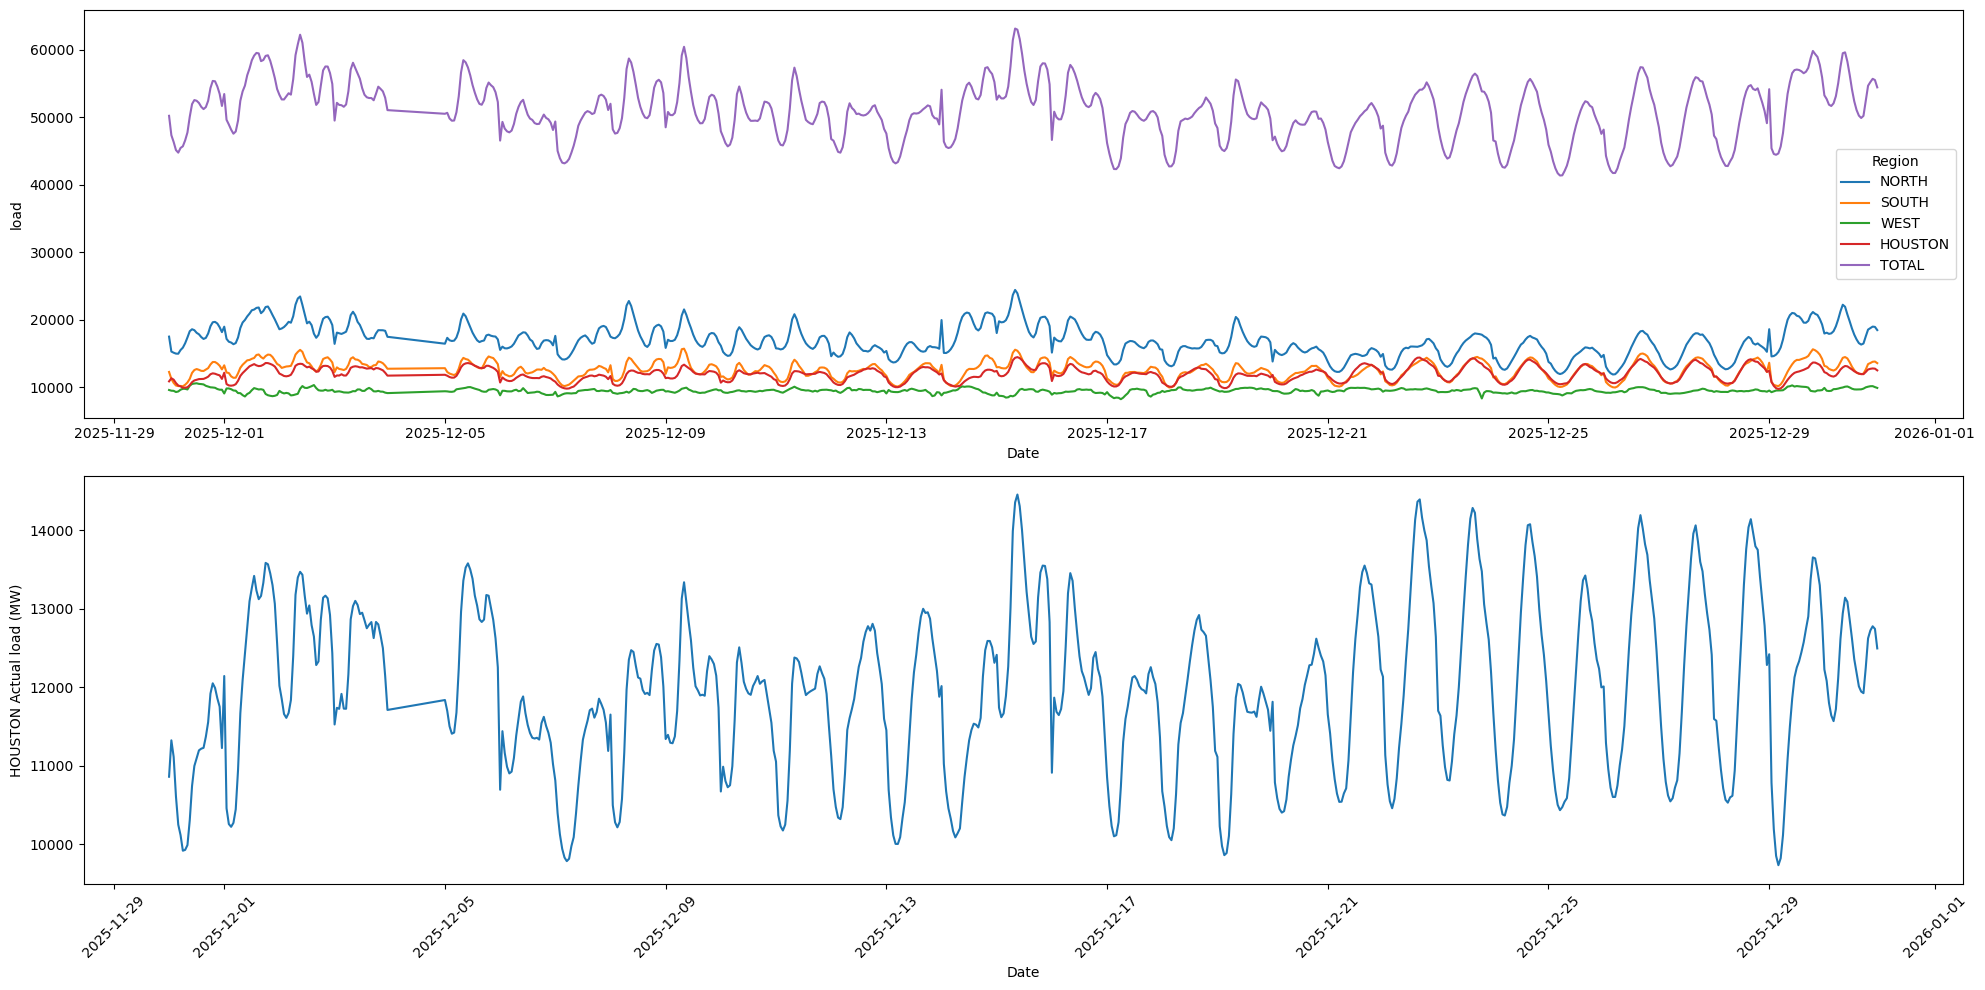

In [56]:
melt = pd.melt(dg[['Date','NORTH','SOUTH','WEST','HOUSTON','TOTAL']], id_vars='Date',var_name='Region',value_name='load')

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

sns.lineplot(melt, x='Date',y='load',hue='Region', ax=axes[0])
sns.lineplot(dg,x='Date',y='HOUSTON',ax=axes[1])

plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('HOUSTON Actual load (MW)')

plt.show()

In [59]:
dg2 = data_dict[list[2]]
dg3 = data_dict[list[3]]

dg2.columns, dg3.columns


(Index(['SCEDTimestamp', 'RepeatedHourFlag', 'SettlementPoint', 'LMP'], dtype='str'),
 Index(['DeliveryDate', 'DeliveryHour', 'DeliveryInterval',
        'SettlementPointName', 'SettlementPointType', 'SettlementPointPrice',
        'DSTFlag'],
       dtype='str'))

In [62]:
dg3.sample(10)

,DeliveryDate,DeliveryHour,DeliveryInterval,SettlementPointName,SettlementPointType,SettlementPointPrice,DSTFlag
1125377,12/11/2025,20,2,FORMOSA_CC2,LCCRN,38.11,N
2438671,12/24/2025,10,4,EVLN_ESS_RN,RN,21.36,N
2587448,12/25/2025,20,4,TTWEC_G1,RN,6.75,N
2610710,12/26/2025,1,2,DUP_PUN4,PUN,9.28,N
2145677,12/21/2025,14,1,DIB_DIB_G4,PCCRN,23.07,N
1830998,12/18/2025,14,2,ELS_RN_1,RN,11.20,N
542159,12/06/2025,6,4,RTLSNAKE_BT,RN,70.16,N
2354931,12/23/2025,14,1,GUADG_CCU2,PCCRN,20.63,N
1858250,12/18/2025,20,1,FAL_FALCONG1,RN,24.56,N
1930264,12/19/2025,13,3,HOVEY_GEN,RN,-0.43,N


<i>We have to figure out what the various settlement point names are, and narrow down our search to Houston area.</i>